In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import sys

address = 'CDG-for-jupyter-notebooks/pytorch'
sys.path.append(f'content/drive/MyDrive/{address}')

%cd /content/drive/MyDrive/$address
%pwd

/content/drive/.shortcut-targets-by-id/1B4C1kny-eK7mHVSC0X2Mrtd3TTm1K3nU/CDG-for-jupyter-notebooks/pytorch


'/content/drive/.shortcut-targets-by-id/1B4C1kny-eK7mHVSC0X2Mrtd3TTm1K3nU/CDG-for-jupyter-notebooks/pytorch'

In [1]:
!pip install colab_ssh --upgrade
from colab_ssh import launch_ssh_cloudflared, init_git_cloudflared
launch_ssh_cloudflared(password="1")

# Importing Required Pacakages


### Torch
- **torch.nn**: Contains all neural network modules. Contains the loss functions.
- **torch.optim**: Contains all optimizers.
- **torch.nn.functional**: Functions that require no hyper parameter (like activation functions). They can also be found in the torch.nn module (a little confusing).
- **torch.utils.data.DataLoader**:  Dataset Management Module (mini batches, etc.).
- **torchvision.datasets**: Torch's Standard Datasets
- **torchvision.transforms**: Contains the some dataset transformations.

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torch.utils.tensorboard import SummaryWriter

- **os**: loading file paths.
- **pandas**: for lookup in annotation file.
- **spacy**: for tokenizing.
- **torch.nn.utils.rnn.pad_sequence**: pad batch.
- **PIL.Image**: loading images.


In [ ]:
import os
from collections import defaultdict

import spacy
from torch.nn.utils.rnn import pad_sequence
from PIL import Image

### Miscellaneous

In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Set Device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Utils

In [ ]:
def to_device(device, *tensors):
  in_device_tensors = []
  for tens in tensors:
    in_device_tensors.append(tens.to(device=device))
  return tuple(in_device_tensors)

# Model Implementation

In [ ]:
class BaseImageCaptionerArchitecture(nn.Module):
  def calculate_image_output_size(self):
    raise NotImplementedError()

  def calculate_ff_input_size(self):
    raise NotImplementedError()

  def __init__(self, image_module, rnn_module, ff_module, image_size, word_size, hidden_size, output_size):
    super().__init__()
    self.image_size = image_size
    self.word_size = word_size
    self.hidden_size = hidden_size
    self.image_output_size = calculate_image_output_size()
    self.ff_input_size = calculate_ff_input_size()
    self.image_processor = image_module(image_size, self.image_output_size)
    self.rnn_processor = rnn_module(word_size, self.hidden_size)
    self.ff_processor = ff_module(self.ff_input_size, self.output_size)

  def forward(self, image, caption):
    raise NotImplementedError()

class MergeImageCaptionerArchitecture(BaseImageCaptionerArchitecture):

## CNN for Encoder

In [ ]:
class EncoderCNNDepricated(nn.Module):

  def __init__(self, embed_size, train_CNN=False):
    super().__init__()
    self.embed_size = embed_size
    self.train_CNN = train_CNN
    self.inception = models.inception_v3(pretrained=True, aux_logits=True)
    self.inception.fc = nn.Linear(self.inception.fc.in_features, self.embed_size)
    self.dropout = nn.Dropout(.5)

  def forward(self, images):
    features = self.inception(images)

    for name, param in self.inception.named_parameters():
      if 'fc.weight' in name or 'fc.bias' in name:
        param.requires_grad = True  # Fine tuning
      else:
        param.requires_grad = self.train_CNN

      features = F.relu(features)
      return self.dropout(features)

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.conv1 = nn.Conv3d(
            in_channels=1, out_channels=8, kernel_size=(3, 17, 17),
            stride=(1, 1, 1), padding=(1, 0, 0),
        )
        self.conv2 = nn.Conv3d(
            in_channels=8, out_channels=16, kernel_size=(3, 17, 17),
            stride=(1, 1, 1), padding=(1, 0, 0),
        )

        self.conv3 = nn.Conv3d(
            in_channels=16, out_channels=24, kernel_size=(3, 17, 17),
            stride=(1, 1, 1), padding=(1, 0, 0),
        )

        # see the forward function to understand the shapes
        self.fc1 = nn.Linear(38088, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, embed_size)

        """
          - makes the frame size half.
          - pool has no learning parameter and can be reused.
        """
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x.shape: [batch, 3, 299, 299]
        x = x.unsqueeze(1)  # shape: [batch, 1, 3, 299, 299]

        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = self.relu(self.conv3(x))
        x = self.pool(x)

        x = self.flatten(x)  # shape: (batch, 38088)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return self.dropout(x)  # shape: (batch, embed_size)


## RNN for Decoder

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        # input_size, hidden_size, num_layers
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(.5)

    # features from encoder, captions from target captions
    def forward(self, features, captions):
        # features.shape: (batch, embed_size)
        # captions.shape: (seq_length, batch)
        embeddings = self.embed(captions)  # shape: (seq_length, batch, embed_size)
        embeddings = self.dropout(embeddings)

        features = features.unsqueeze(0)  # shape: (1, batch, embed_size)
        embeddings = torch.cat((features, embeddings), dim=0)  # shape: (1 + seq_length, batch, embed_size)

        outputs, _ = self.lstm(embeddings)
        # outputs.shape: (1 + seq_length, batch, hidden_size)
        outputs = self.linear(outputs)  # shape: (1 + seq_length, batch, vocab_size)
        return outputs


## CNN to RNN Hook

In [ ]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super().__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length):
        result_caption = []
        self.eval()
        with torch.no_grad():
            # unsqueeze the dimension for the batch
            # since we are predicting only one image
            # image.shape = (1, 3, 299, 299)
            x = self.encoder(image)  # shape = (1, embed_size)
            x = x.unsqueeze(0)  # (1, 1, embed_size)

            states = None  # going to be hidden and the cell state of the LSTM

            for _ in range(max_length):
                outputs, states = self.decoder.lstm(x, states)
                # outputs.shape: (1, 1, 384)
                outputs = outputs.squeeze(0)  # shape: (1, 384)
                outputs = self.decoder.linear(outputs)  # shape: (1, vocab_size)
                predicted = outputs.argmax(1)  # shape: (1,)

                result_caption.append(predicted.item())
                x = self.decoder.embed(predicted).unsqueeze(0)
                # x.shape: (1, 1, embed_size)

                if vocabulary.itos[predicted.item()] == '<EOS>':
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

# Data Loading

## Vocabulary
- `freq_threshold`: ignore the word if it is not repeated this amount of times.

In [ ]:
!python -m spacy download en_core_web_md

2023-09-10 09:29:16.745214: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
class Vocabulary:
    spacy_eng = spacy.load('en_core_web_md')

    def __init__(self, freq_threshold: int):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v: k for k, v in self.itos.items()}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @classmethod
    def tokenizer_eng(cls, text):
        return [tok.text.lower() for tok in cls.spacy_eng.tokenizer(text)]

    def build(self, sentence_list):
        freqs = defaultdict(lambda: 0)
        idx = 4
        for sent in sentence_list:
            for word in self.tokenizer_eng(sent):
                freqs[word] += 1
                if freqs[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        return [
            self.stoi.get(token, self.stoi['<UNK>'])
            for token in self.tokenizer_eng(text)
        ]


## Dataset

In [ ]:
class FlickrDataset(Dataset):
    def __init__(
            self, root_dir, captions_file, imgs_dir,
            vocabulary, transform=None
    ):
        self.root_dir = root_dir
        self.captions_file = captions_file
        self.imgs_dir = imgs_dir
        self.transform = transform

        self.df = pd.read_csv(os.path.join(self.root_dir, self.captions_file), delimiter='\t')

        self.vocab = vocabulary
        self.vocab.build(self.captions.tolist())

    @property
    def captions(self):
        return self.df['caption']

    @property
    def imgs(self):
        return self.df['image']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(
            os.path.join(self.root_dir, self.imgs_dir, img_id)
        ).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        # stoi: string to index, SOS: start of sentence
        numericalized_caption = [
            self.vocab.stoi['<SOS>'],
            *self.vocab.numericalize(caption),
            self.vocab.stoi['<EOS>'],
        ]
        return img, torch.tensor(numericalized_caption)


## Padding

pad EACH BATCH to the maximum length sentence of that batch.

In [ ]:
class MyCollate:

    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)
        return imgs, targets


## DataLoader

In [ ]:
def get_loader(
        root_dir,
        captions_file,
        imgs_dir,
        transform,
        batch_size,
        num_workers=0,
        shuffle=True,
        pin_memory=True,
):
    vocab = Vocabulary(5)
    dataset = FlickrDataset(root_dir, captions_file, imgs_dir, vocab, transform)
    pad_idx = vocab.stoi['<PAD>']
    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )
    return loader, dataset

### Test Data Loading

In [ ]:
# transforms_ = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor()
# ])
# dataloader = get_loader(
#     'dataset/flickr8k', 'captions.txt', 'images', transforms_, batch_size=100,
#     num_workers=2,
#     )

# for idx, (imgs, captions) in enumerate(dataloader):
#   print(idx)
#   print(imgs.shape)
#   print(captions.shape)
#   if idx == 4:
#     break

## DataLoader for the Problem

In [ ]:
transform = transforms.Compose([
    transforms.Resize((356, 356)),
    transforms.RandomCrop((299, 299)),  # since inception_v3 accepts inputs of this size
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5)),
])
train_loader, dataset = get_loader(
    'dataset/flickr8k', 'captions.txt', 'images', transform, batch_size=128,
    num_workers=2, shuffle=False,
)

In [ ]:
# test dataset and the loader
t = dataset[0][0]
t.shape

torch.Size([3, 299, 299])

# Hyper Parameters

In [ ]:
embed_size = 256
hidden_size = 384
vocab_size = len(dataset.vocab)
num_layers = 1
lr = 3e-4
epochs = 1

# Tensorboard
writer = SummaryWriter('runs/flickr')
step = 0

# Model Initializing

In [ ]:
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)

# Loss and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=lr)

# Model Training
#### Note 1
We are not sending the last token so that the model actually learns to predict the end token (`'<EOS>'`).
#### Note 2
CrossEntropyLoss gets two arguemnts. first is of the shape `(batch, labels)` and the second is of the shape `(batch)`.
But in this problem model `outputs` has the shape of `(sequence_length, batch, vocabulary_size)` and the `targets` has the shape of `(sequence_length, batch)`. so we reshape them to `(sequence_length * batch, vocabulary_size)` and `(sequence_length * batch)`
respectively.

In [ ]:
model.train()

for epoch in range(epochs):
    print(f'EPOCH {epoch + 1} Has Started...')
    for idx, (imgs, captions) in tqdm(enumerate(train_loader)):
        # imgs, captions = to_device(device, imgs, captions)
        """
        not sending the last token so that the model actually learns to
        predict the end token (<EOS>).
        """
        outputs = model(imgs, captions[:-1])

        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
        )

        writer.add_scalar("Training Loss", loss.item(), global_step=step)
        step += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # remove the following line for complete learning
        if step == 50:
          break


KeyboardInterrupt: ignored

# Model Evaluation

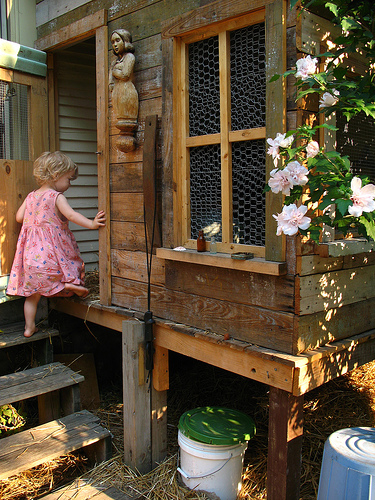

In [ ]:
img = Image.open(
    os.path.join('dataset/flickr8k', 'images', '1000268201_693b08cb0e.jpg')
).convert('RGB')
display(img)
tr_img = transform(img)

In [ ]:
tr_img = tr_img.to(device)
tr_img = tr_img.unsqueeze(0)
caption_list = model.caption_image(tr_img, dataset.vocab, max_length=50)
print(caption_list)
print(' '.join(caption_list))

['<SOS>', 'a', 'a', 'a', 'in', 'a', 'in', '.', '<EOS>']
<SOS> a a a in a in . <EOS>
